# Imports

In [1]:
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import boxcox, chi2_contingency, f_oneway, probplot
import seaborn as sns

In [2]:
sns.set_palette("pastel")

# Loading

In [3]:
# Loaded here because being default argument in some functions
cleaned_df = pd.read_csv("csvs/cleaned_dataset.csv")
cleaned_df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

# Functions

In [4]:
def bar_chart(df:pd.DataFrame, var: str, out: bool = False) -> None:
    """
    TO DO: docstring
    """
    total = len(df)
    ax = sns.countplot(x=var, data=df,
                       hue=var)
    
    for p in ax.patches:
        height = p.get_height()
        percentage = '{:.0f}%'.format(100 * height/total)
        ax.text(p.get_x() + p.get_width() / 2., height + 3, percentage, ha="center")
        ax.set_title(f"{var}'s bar chart",
                     size="x-large", weight="bold", color="blue")

    if out:
        plt.savefig(f"graphs/{var}_bar_chart.png", dpi=300)
    
    plt.show()

In [5]:
def contingency_table(
    var1: str, var2: str, df: pd.DataFrame = cleaned_df,
    out: bool = True) -> pd.DataFrame:
    """
    Get the contingency table for two nominal features of a DataFrame
    `out` set to True allows to export the output in .csv format in csvs folder.
    """
    ct = pd.crosstab(df[var1], df[var2])
    if out:
        ct.to_csv(f"csvs/{var1}_{var2}_ct.csv", index=True)
    return ct

In [6]:
def correlation_heatmap(df: pd.DataFrame = cleaned_df, out: bool = True) -> None:
    """
    Displays correlations between numerical features of a DataFrame.
    `out` set to True allows to export the graph in png format in the graphs folder.
    """
    corr = df.select_dtypes(include="number").corr()
    # Create a matrix full of zeros similar to corr
    mask = np.zeros_like(corr)
    # Set the upper triangle of the mask to True
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
      fig, ax = plt.subplots(figsize=(6, 6))
      ax = sns.heatmap(
        corr,
        # MASK
        mask=mask,
        # Div palette, suffix _r to reverse
        cmap="RdBu_r", # coolwarm, vlag, icefire
        # Text in heatmap
        annot=True,# Allowing annotations.
        fmt=".2f", # Formatting annotations. 
        annot_kws=dict(
          fontsize=9,
          fontweight="bold"
          ), # Other formatting
        # Values on vertical colorbar
        vmax=1,
        center=0,
        vmin=-1,
        )
    plt.title("Correlations Heatmap", size="xx-large", weight="bold", c="b")

    if out:
        plt.savefig("graphs/correlations_heatmap.png", dpi=300)
        
    plt.show()

In [7]:
def cramers_v(ct: pd.DataFrame, chi2: float) -> float:
    """
    Perform Cramer's V test to measure correlation between two nominal variables,
    Params
    ------
        ct: the observed contingency table,
        chi2: the chi2 result of scipy.stats.contingency function on ct.
    """
    n = ct.sum().sum()  # Retrieve the number of observations
    n_rows, n_cols = ct.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - (n_rows - 1) * (n_cols - 1) / (n - 1))
    row_corr = n_rows - ((n_rows - 1) ** 2) / (n - 1)
    col_corr = n_cols - ((n_cols - 1) ** 2) / (n - 1)
    cramer_v = np.sqrt(phi2corr / min(row_corr - 1, col_corr - 1))
    return cramer_v

In [8]:
def draw_probplot(var: str, df: pd.DataFrame = cleaned_df, out: bool = False) -> None:
    """
    Draw a qqplot of the variable to check its normality.
    `out` set to True allows to export the graph in .png format in the graphs folder.
    """
    probplot(df[var], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {var}",
              size="x-large", weight="bold", color="blue")
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')

    if out:
       plt.savefig(f"graphs/{var}_qqplot.png", dpi=300)

    plt.show()

In [9]:
def extract_var_outliers(df: pd.DataFrame, var: str, out: bool = False) -> pd.DataFrame:
    """
    Spots outliers (according to how they're defined on a boxplot)
    from the feature `feat` of the DataFrame `df`
    `out` is a boolean specifying if an export to a csv file in the current folder is needed.
    """
    q1, q3 = df[var].quantile([.25, .75])
    iqr = q3 - q1
    outliers = df[df[var] > q3 + 1.5 * iqr]
    if out:
        outliers.to_csv(f"csvs/{var}_outliers.csv", index=False)
    return outliers

In [10]:
def hist_box_plot(df: pd.DataFrame, col: str, out: bool = False) -> None:
    """
    Display an histogram and a boxplot of df[col],
    col being a continuous numerical variable.
    Specifying `out` to True allows to export the graph in .png format.
    """
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode().values[0]
     
    sns.boxplot(data=df, x=col, ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')
     
    sns.histplot(data=df, x=col, ax=ax_hist, kde=True)
    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
    ax_hist.axvline(median, color='g', linestyle='-', label="Median")
    ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
     
    ax_hist.legend(loc='best')
     
    ax_box.set(xlabel='')

    plt.suptitle(f"Distribution of {col} variable",
                 size="x-large", weight="bold", color="blue")

    if out:
        plt.savefig(f"graphs/{col}_hist_box.png", dpi=300)
        
    plt.show()

In [11]:
def lineplot(x: str, y: str, df: pd.DataFrame,
             cat: Optional[str] = None,
             estimator: str = "mean",
             out:bool = False) -> None:
    """
    TO DO: docstring
    """
    sns.relplot(x=x, y=y, data=df,
                kind="line",
                estimator=estimator,
                hue=cat,
                col=cat, col_wrap=df[cat].nunique() // 2 if cat else None)
    graph_title = f"Line plot of {estimator} {y} by {x}"
    file_name = f"line_plot_{estimator}_{y}_by_{x}"
    
    if cat:
        graph_title += f" and {cat}"
        file_name += f"_and_{cat}"
        
    plt.suptitle(graph_title, size="x-large", weight="bold", color="blue",
                 y=1.05)

    if out:
        plt.savefig(f"graphs/{file_name}.png", dpi=300)

    plt.show()    

In [12]:
def one_way_anova(
    nom_var: str, num_var: str = "charges",
    df: pd.DataFrame = cleaned_df
) -> Tuple[float, float]:
    """
    Perform one way ANOVA between a nominal variable and a numerical one,
    using `f_oneway` function from `scipy.stats`
    `num_var` is set by default to the target: `charges` of
    `cleaned_df`, which is the default `df`.
    """
    grouped_data = [group[num_var].values
                    for name, group in df.groupby(nom_var)]
    f_statistic, p_value = f_oneway(*grouped_data)
    return f_statistic, p_value

In [13]:
def pairplot(df: pd.DataFrame = cleaned_df,
             cat: Optional[str] = None,
             out: bool = False) -> None:
    """
    TO DO
    """
    sns.pairplot(data=df, hue=cat)
    title = "Pair Plot"
    if cat:
        title += f" Colored by {cat}"

    plt.suptitle(title,
                 size="x-large", weight="bold", color="blue",
                 y=1)

    if out:
        file_name = "pairplot"
        if cat:
            file_name += f"_hue_{cat}"
        plt.savefig(f"graphs/{file_name}.png", dpi=300)

    plt.show()  

# Overview

## Numerical

In [14]:
cleaned_df.sample(5)

age     sex     bmi  children smoker     region      charges
1164   35  female  26.125         0     no  northeast   5227.98875
278    59    male  31.790         2     no  southeast  12928.79110
533    37    male  36.190         0     no  southeast  19214.70553
797    58  female  33.100         0     no  southwest  11848.14100
185    36    male  41.895         3    yes  northeast  43753.33705

In [15]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [16]:
cleaned_df.describe()

age          bmi     children       charges
count  1337.000000  1337.000000  1337.000000   1337.000000
mean     39.222139    30.663452     1.095737  13279.121487
std      14.044333     6.100468     1.205571  12110.359656
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.290000     0.000000   4746.344000
50%      39.000000    30.400000     1.000000   9386.161300
75%      51.000000    34.700000     2.000000  16657.717450
max      64.000000    53.130000     5.000000  63770.428010

## Graphical (pairplots)

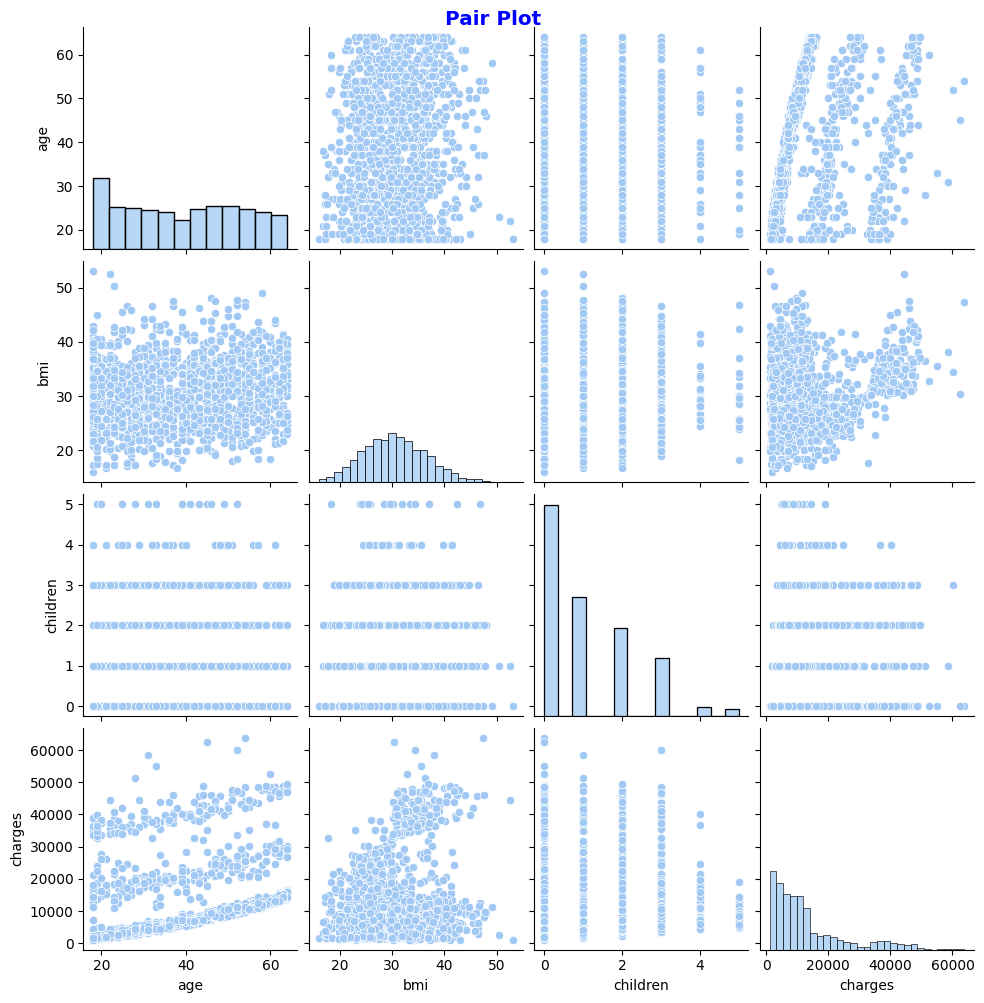

In [17]:
pairplot(out=True)

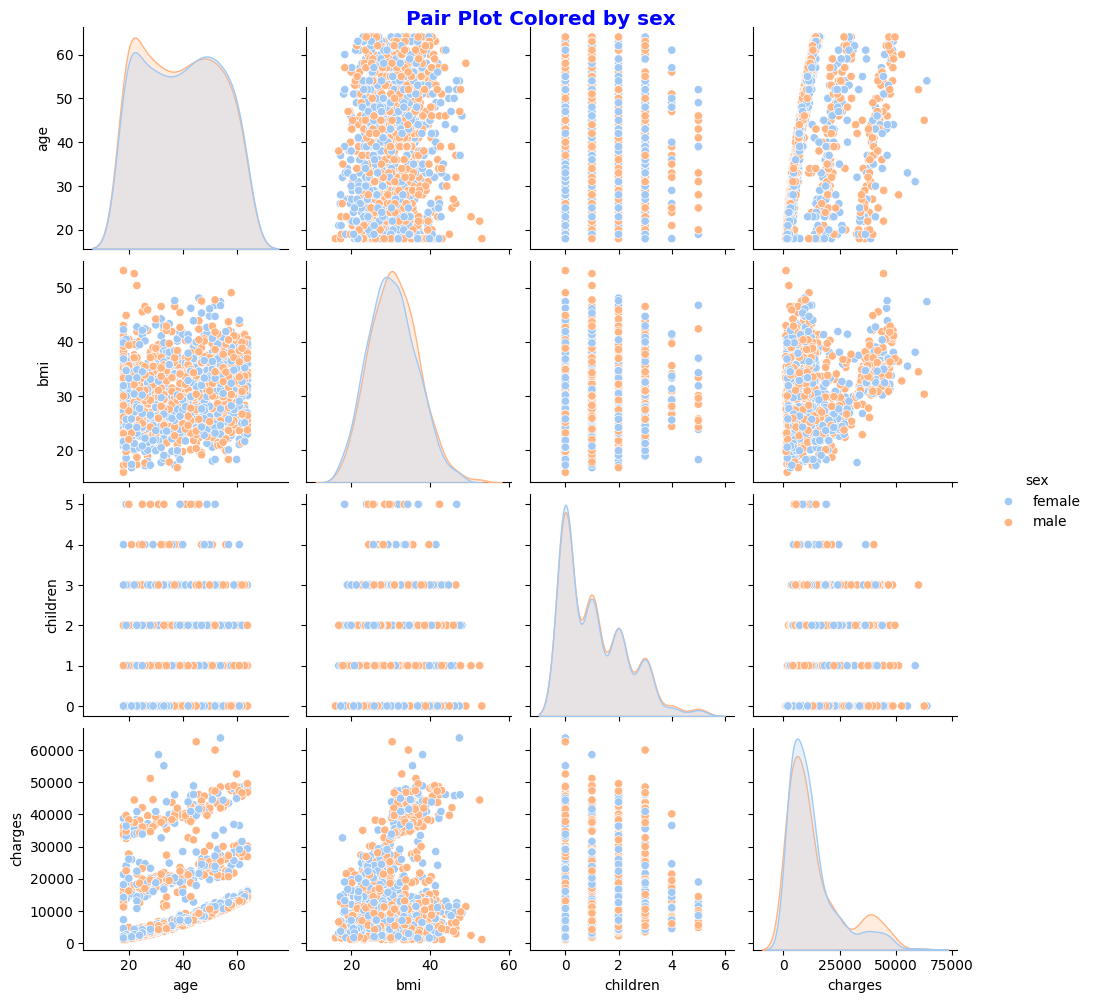

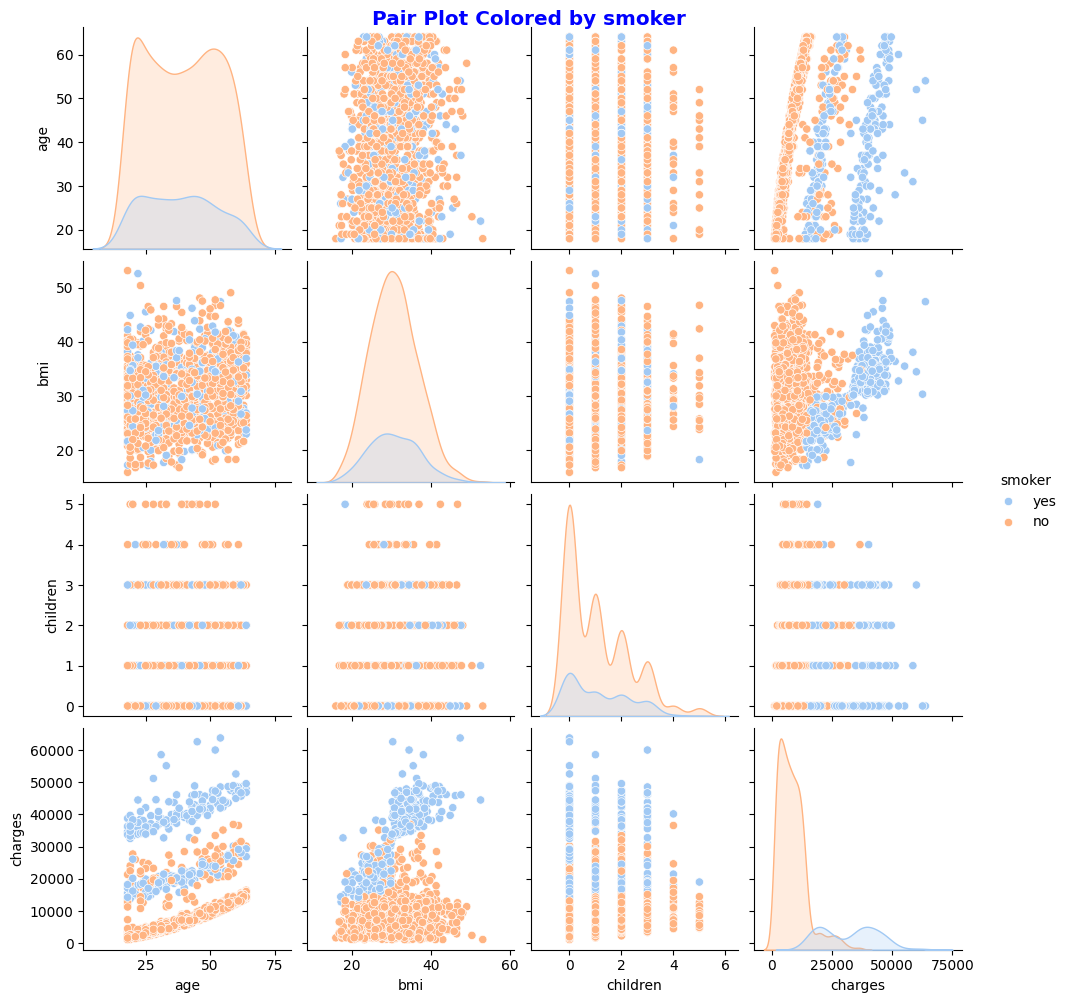

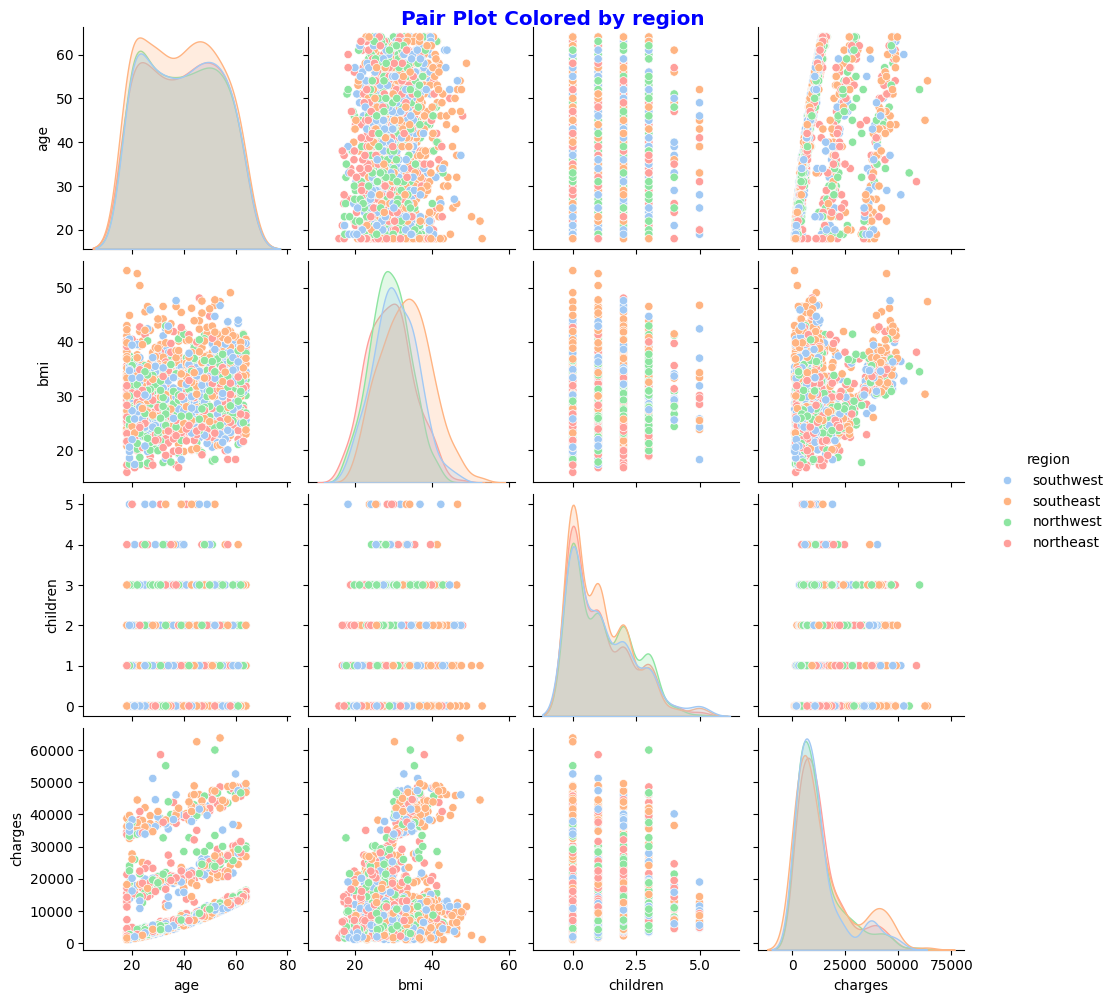

In [18]:
for cat in cleaned_df.select_dtypes(include="object").columns:
    pairplot(cat=cat, out=True)

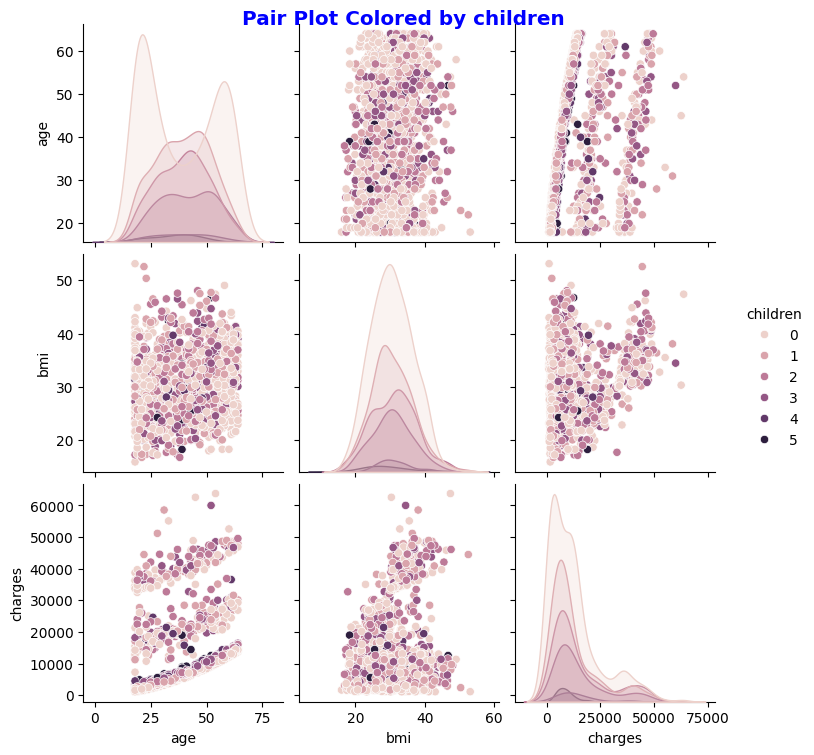

In [19]:
pairplot(cat="children", out=True)

# Univariate Analysis

## Numerical Features + target

### Plots

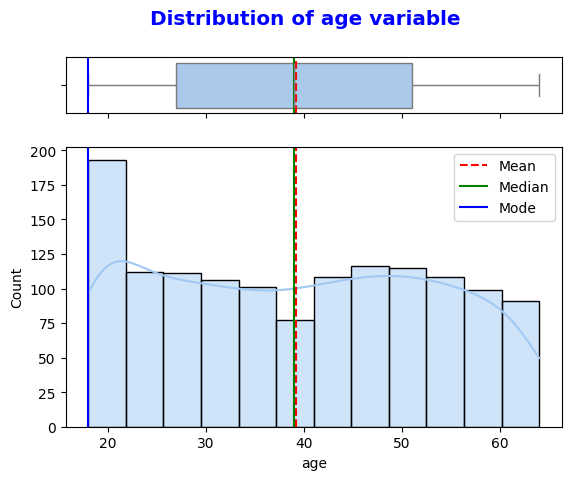

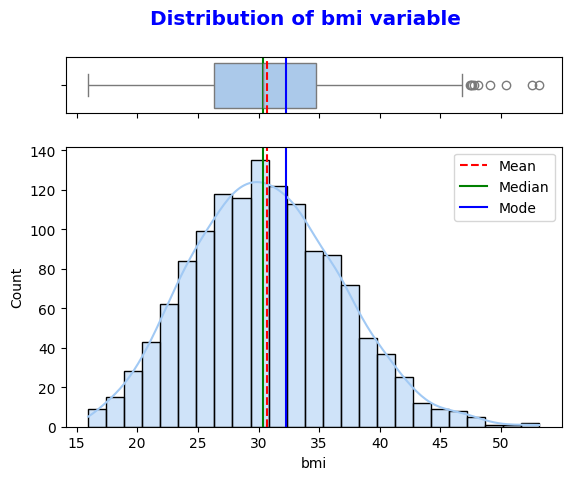

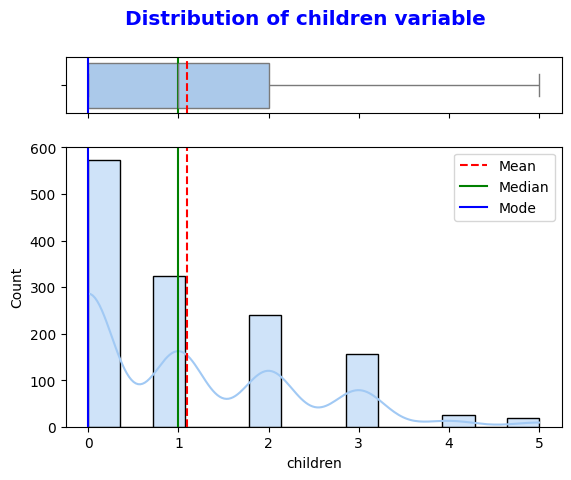

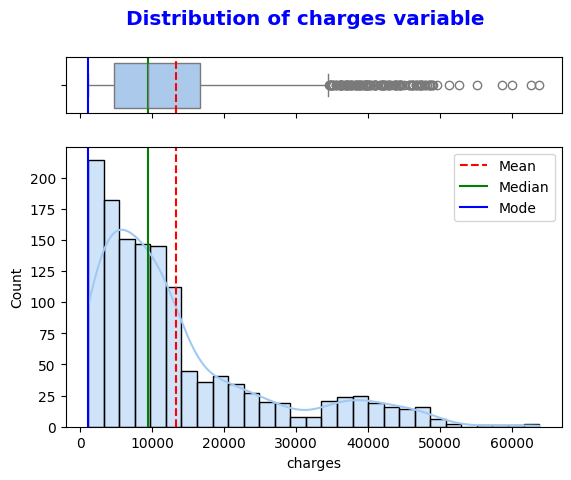

In [20]:
for col in cleaned_df.select_dtypes(exclude="object").columns:
    hist_box_plot(cleaned_df, col, out=True)

### Analysis

#### age

👉 `age` is a rather uniform distribution, as mean and median are centered, except for a mode located on young people, being majoritary around 18 and 19.

In [21]:
cleaned_df.age.value_counts()

age
18    69
19    67
50    29
51    29
47    29
46    29
45    29
20    29
48    29
52    29
22    28
49    28
54    28
53    28
21    28
26    28
24    28
25    28
28    28
27    28
23    28
43    27
29    27
30    27
41    27
42    27
44    27
31    27
40    27
32    26
33    26
56    26
34    26
55    26
57    26
37    25
59    25
58    25
36    25
38    25
35    25
39    25
61    23
60    23
63    23
62    23
64    22
Name: count, dtype: int64

#### bmi

👉 `bmi` seems to follow a "normal-like" distribution, as the three central tendancies are centered.

Nevertheless, **the boxplot shows some outliers we could take profit to study**, in regard to how high their charges should be. (and in correlation, maybe, to other health-issuing factors)

In [22]:
bmi_outliers = extract_var_outliers(cleaned_df, "bmi", out=True)

In [23]:
# Checking out
print(f"{bmi_outliers.shape[0] = }")
bmi_outliers

bmi_outliers.shape[0] = 9


age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
846    23    male  50.38         1     no  southeast   2438.05520
859    37  female  47.60         2    yes  southwest  46113.51100
1046   22    male  52.58         1    yes  southeast  44501.39820
1087   52    male  47.74         1     no  southeast   9748.91060
1316   18    male  53.13         0     no  southeast   1163.46270

#### children

👉 Naturally, `children` is skewed to the right, the mode being to 0.

In [24]:
# Percentage distribution
(cleaned_df.children
 .value_counts(normalize=True)
 .apply(lambda x: round(x, 2) * 100)
 .rename("proportion of children")
 # .plot(kind="bar")
)

children
0    43.0
1    24.0
2    18.0
3    12.0
4     2.0
5     1.0
Name: proportion of children, dtype: float64

#### charges

👉 `charges` is skewed to the left, with a "mode" being its lowest value.

Interestingly, **there are a lot of outliers to extract, in order to study them**.

☝️ <font color="orangered">**Maybe there's a portion of them which should be treated as anomalies, but they need to be investigated.**</font>

In [25]:
cleaned_df.charges.describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

In [26]:
charges_outliers = extract_var_outliers(cleaned_df, "charges", out=True)

In [27]:
charges_outliers

age     sex     bmi  children smoker     region      charges
14     27    male  42.130         0    yes  southeast  39611.75770
19     30    male  35.300         0    yes  southwest  36837.46700
23     34  female  31.920         1    yes  northeast  37701.87680
29     31    male  36.300         2    yes  southwest  38711.00000
30     22    male  35.600         0    yes  southwest  35585.57600
...   ...     ...     ...       ...    ...        ...          ...
1299   45    male  30.360         0    yes  southeast  62592.87309
1300   62    male  30.875         3    yes  northwest  46718.16325
1302   43    male  27.800         0    yes  southwest  37829.72420
1312   19  female  34.700         2    yes  southwest  36397.57600
1322   42  female  40.370         2    yes  southeast  43896.37630

[139 rows x 7 columns]

#### 🔎 Investigating `charges` outliers

In [28]:
charges_outliers.describe()

age         bmi    children       charges
count  139.000000  139.000000  139.000000    139.000000
mean    41.079137   35.564604    1.187050  42103.947206
std     13.801420    4.434917    1.126546   5582.168107
min     18.000000   22.895000    0.000000  34617.840650
25%     30.000000   32.667500    0.000000  37786.149950
50%     43.000000   35.200000    1.000000  40974.164900
75%     52.500000   37.660000    2.000000  45786.706425
max     64.000000   52.580000    4.000000  63770.428010

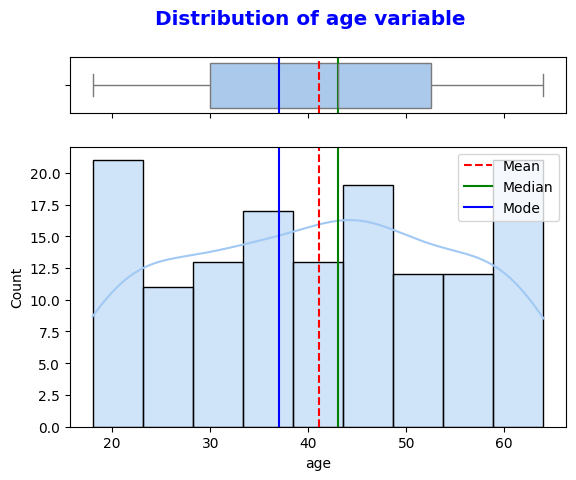

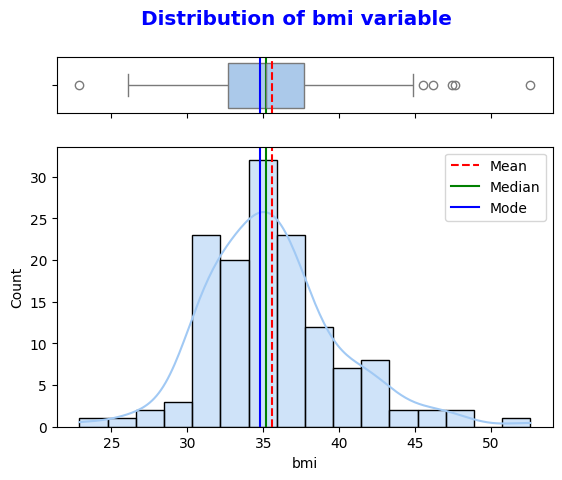

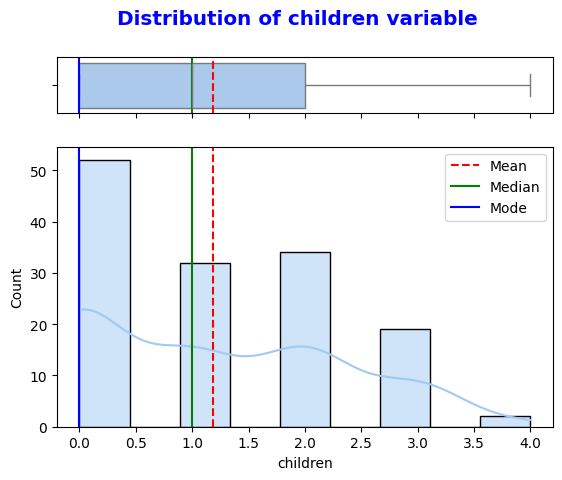

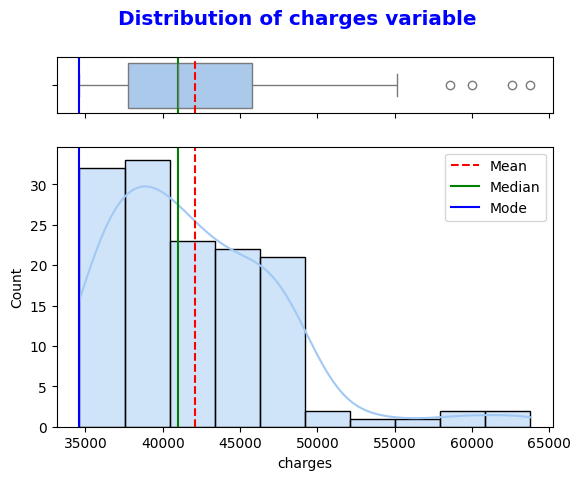

In [29]:
for col in charges_outliers.select_dtypes(exclude="object").columns:
    hist_box_plot(charges_outliers, col, out=False)

## Nominal Features

### Plots

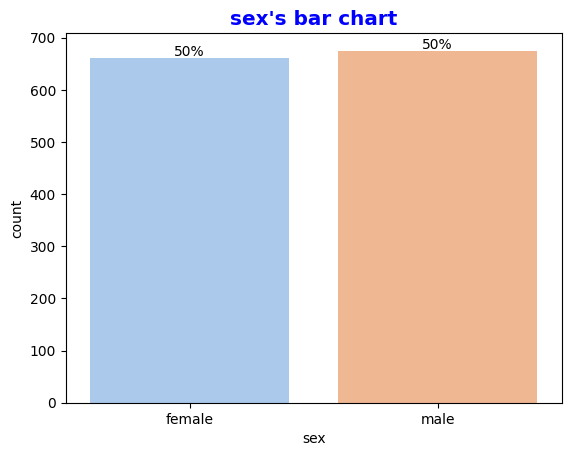

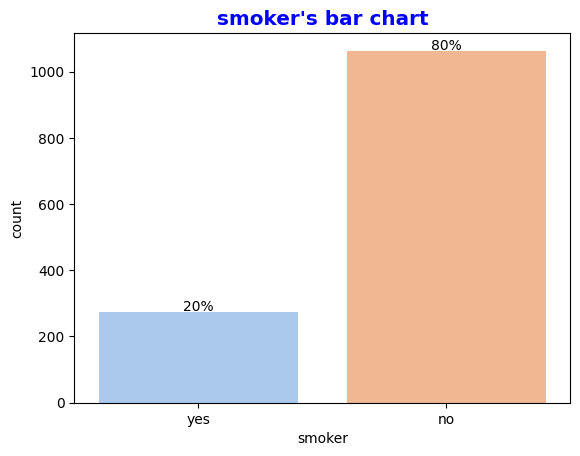

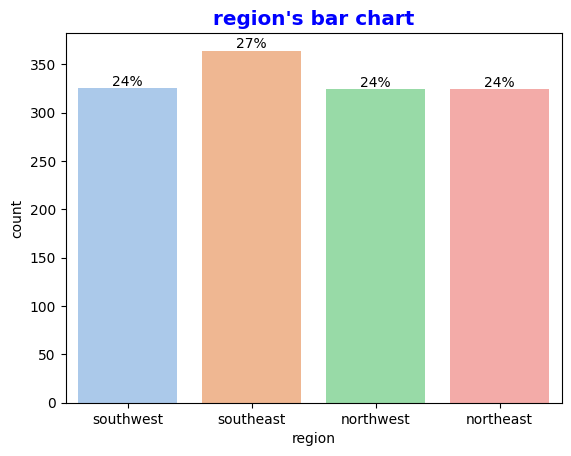

In [30]:
total = len(cleaned_df)

for col in cleaned_df.select_dtypes(include="object").columns:
    bar_chart(cleaned_df, col, out=True)

### Analysis

`sex` and `region` are rather well-balanced, while `smoker` is unbalanced, with a 80%-20% distribution of non-smokers/smokers.

# Bivariate Analysis

## Continuous / Continuous

### `charges` / `age`

#### lineplots (mean, median)

##### `mean` ➡️ **ASCENDING TREND**

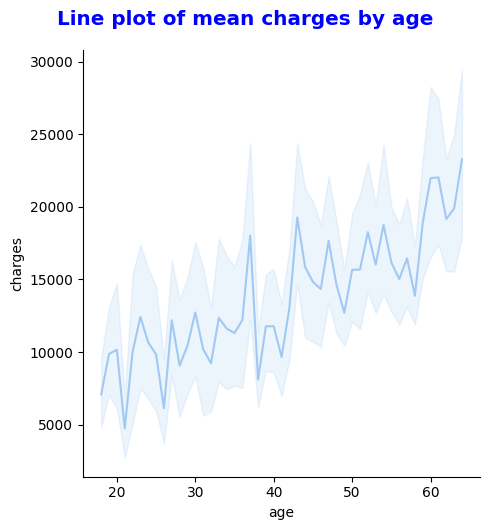

In [31]:
lineplot("age", "charges", cleaned_df, out=True)

##### `median` ➡️ **ASCENDING LINEAR TREND WITH IRREGULARITY AROUND 42 YEARS**

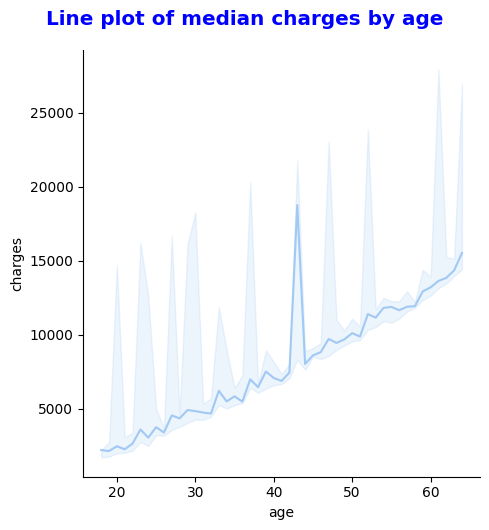

In [32]:
lineplot("age", "charges", cleaned_df, estimator="median", out=True)

##### `std` ➡️ **NO REAL TREND**

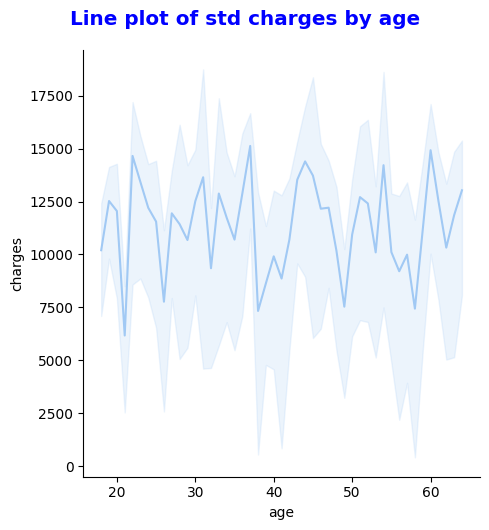

In [33]:
lineplot("age", "charges", cleaned_df, estimator="std", out=True)

#### displot

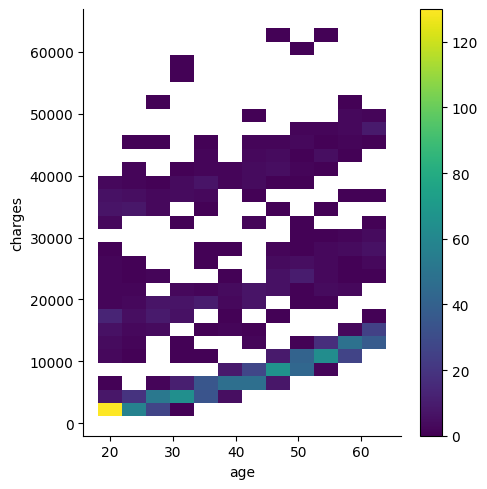

In [34]:
_ = sns.displot(x="age", y="charges", data=cleaned_df,
                cmap="viridis", cbar=True)

#### 🚸 relplot

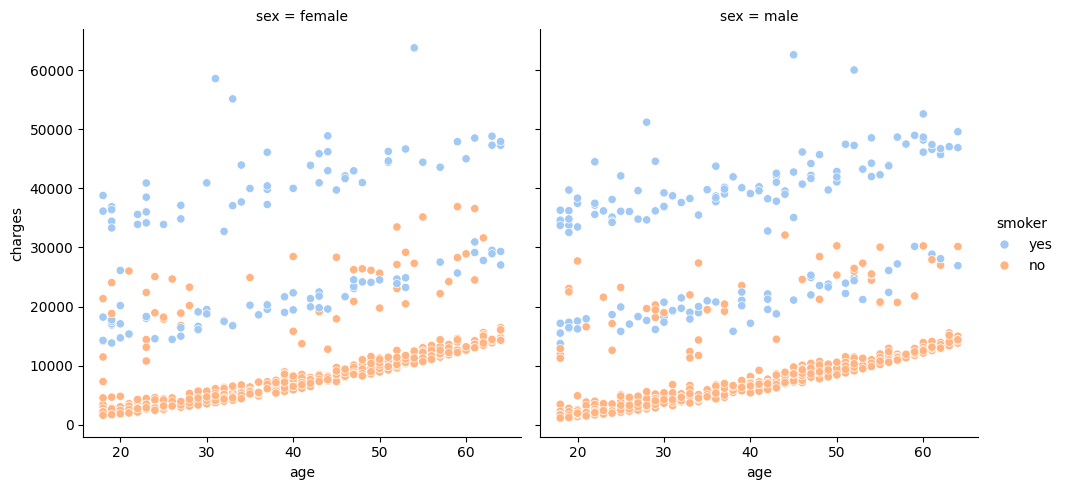

In [35]:
sns.relplot(x="age", y="charges", data=cleaned_df,
            kind="scatter",
            hue="smoker",
            col="sex")
plt.show()

### `charges` / `age` by `region` (lineplots)

#### ➡️ `mean`

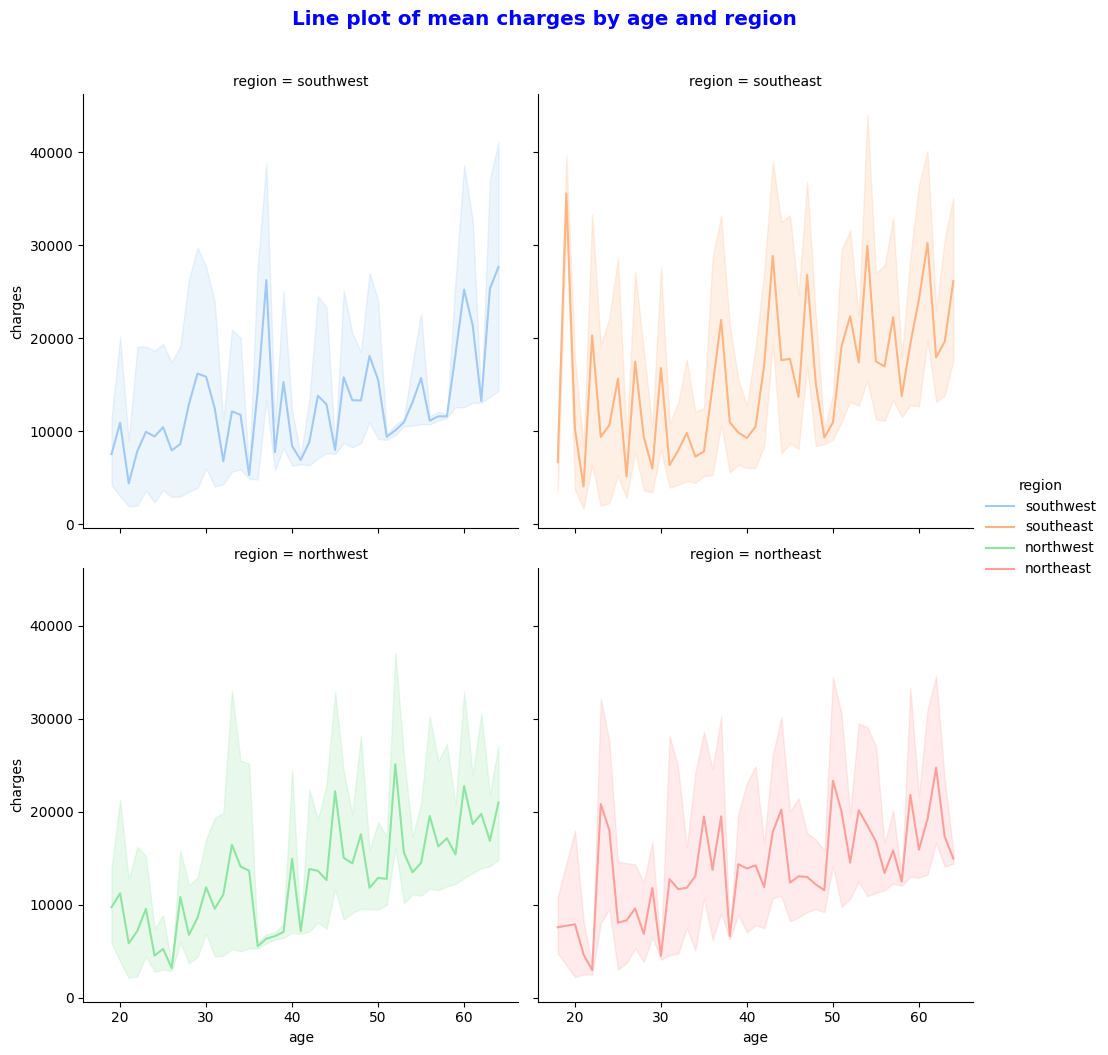

In [36]:
lineplot("age", "charges", cleaned_df, cat="region", out=True)

#### ➡️ `median`

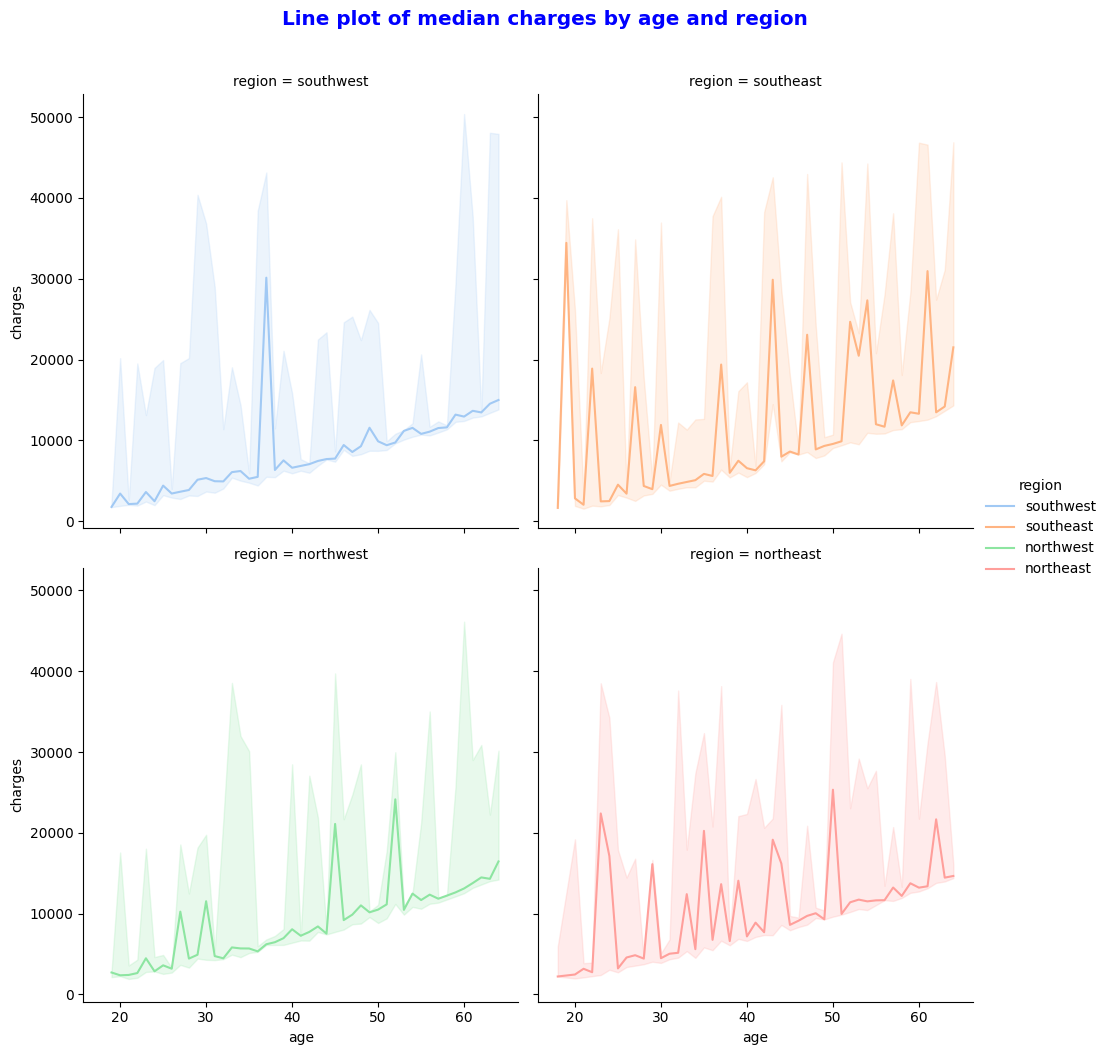

In [37]:
lineplot("age", "charges", cleaned_df, cat="region", estimator="median", out=True)

There's nothing really relevant to say.

### `charges` / `age` by `region`

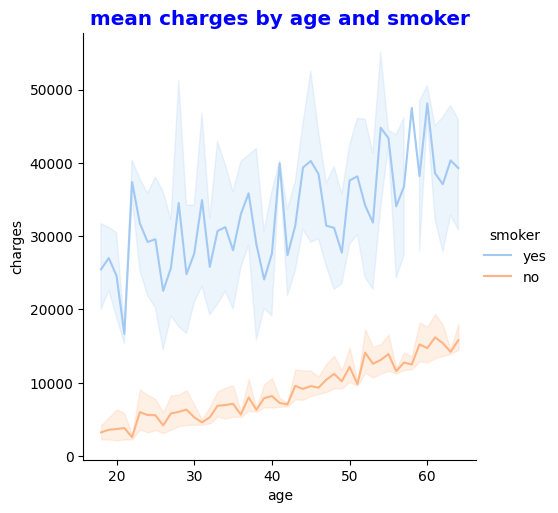

In [38]:
sns.relplot(x="age", y="charges", data=cleaned_df,
            kind="line",
            hue="smoker")
plt.title("mean charges by age and smoker",
          size="x-large", weight="bold", color="blue")
plt.savefig("graphs/charges_by_age_and_smoker.png", dpi=300)

👉 **As expected, charges are really less expensive when you are a non-smoker.**

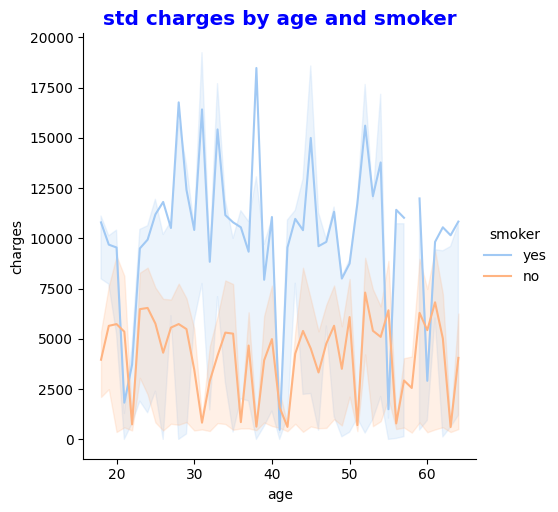

In [39]:
sns.relplot(x="age", y="charges", data=cleaned_df,
            kind="line",
            hue="smoker",
            estimator="std")
plt.title("std charges by age and smoker",
          size="x-large", weight="bold", color="blue")
plt.savefig("graphs/charges_by_age_and_smoker.png", dpi=300)

⚠️ **This one doesn't seem really relevant.**

#### displot

#### Adding `smoker` as `hue`

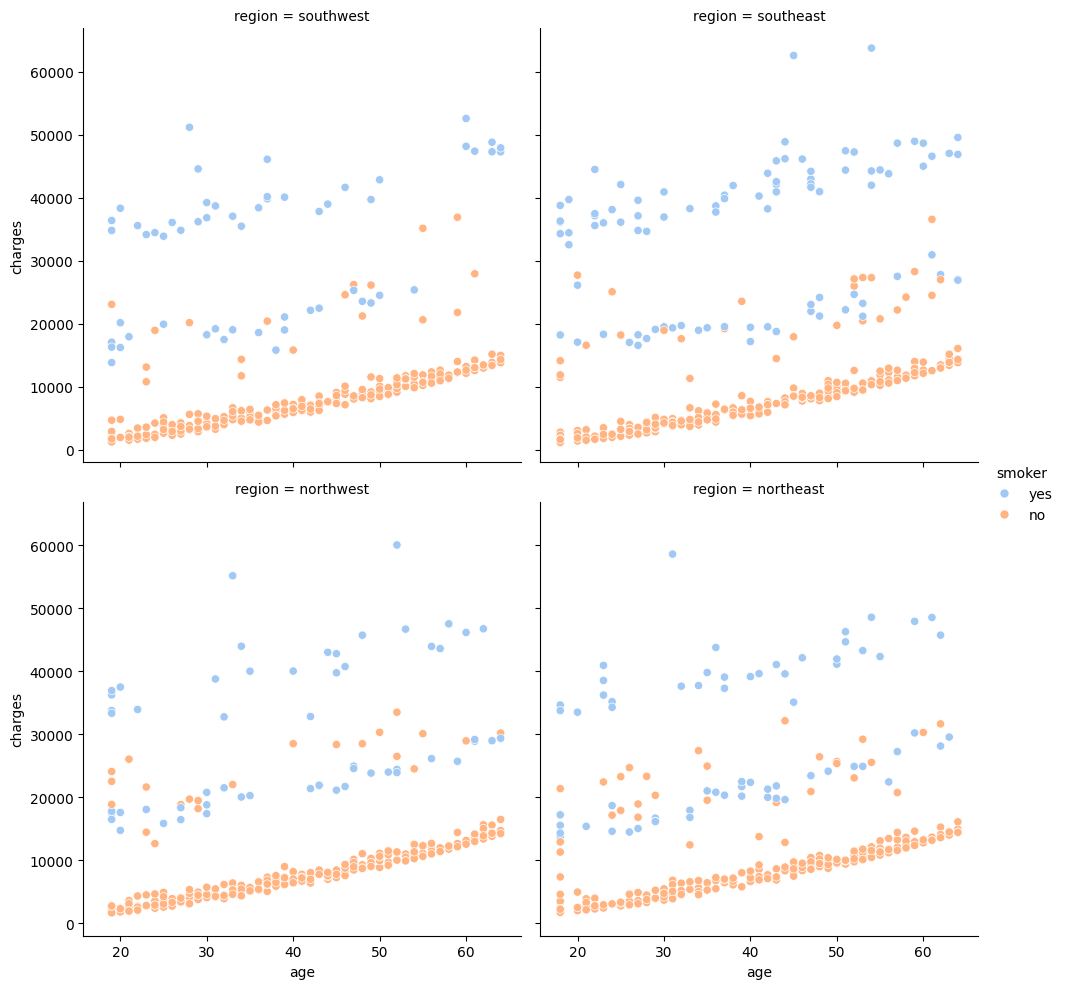

In [40]:
_ = sns.relplot(x="age", y="charges", data=cleaned_df,
                col="region", col_wrap=2,
                hue="smoker")

There's nothing really relevant with `region`, and nothing really surprising with `smoker`

### `charges` / `bmi`

#### lineplot

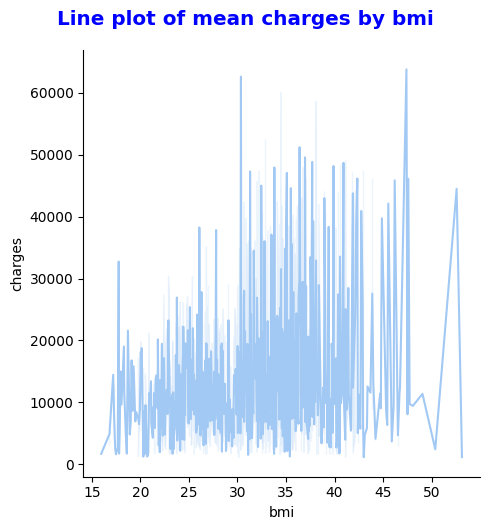

In [41]:
lineplot("bmi", "charges", cleaned_df)

#### relplot

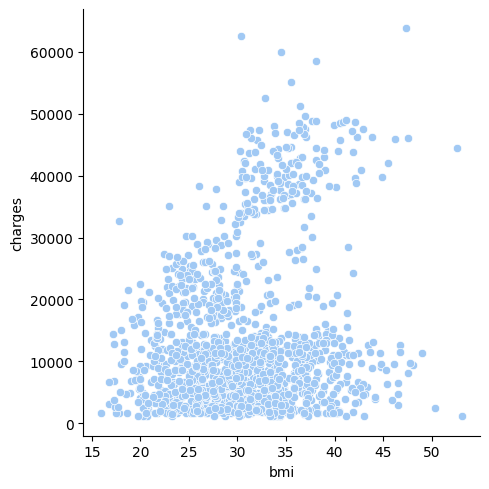

In [42]:
_ = sns.relplot(x="bmi", y="charges", data=cleaned_df)

## Continuous / Nominal

### `charges` / `smoker`

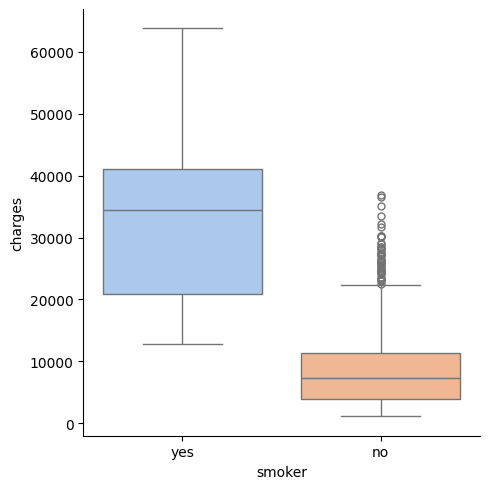

In [43]:
_ = sns.catplot(x="smoker",
                y="charges",
                hue="smoker",
                data=cleaned_df,
                legend=False,
                kind="box")

### `charges` / `sex`

#### Plots and Calculations

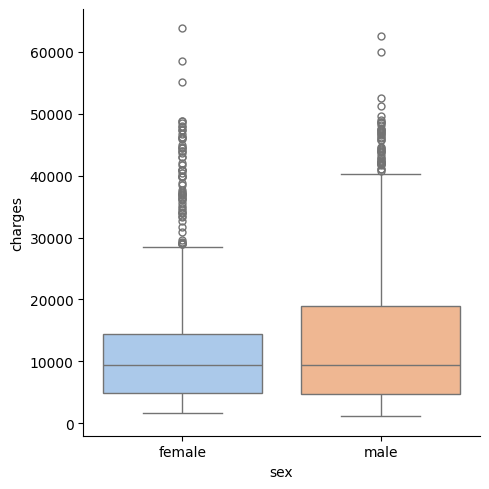

In [44]:
_ = sns.catplot(x="sex",
                y="charges",
                hue="sex",
                data=cleaned_df,
                legend=False,
                kind="box")

⚠️ **Croiser avec les fumeurs**

In [45]:
round(cleaned_df
 .query("sex == 'female'")
 .charges
 .mean(), 2)

12569.58

In [46]:
round(cleaned_df
 .query("sex == 'male'")
 .charges
 .mean(), 2)

13975.0

#### Analysis

👉 **Men tend to pay more than women, $q_3$ being higher for men and their mean too**.

### `charges` / `children`

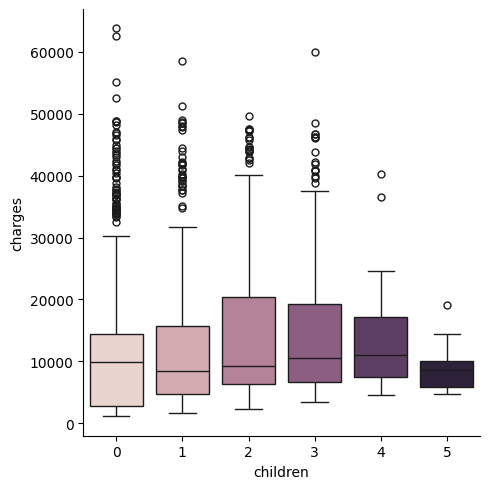

In [47]:
_ = sns.catplot(x="children",
                y="charges",
                hue="children",
                data=cleaned_df,
                legend=False,
                kind="box")

### 6.2.4. `charges` / `bmi` ("nominalized") 💡

#### Four categories

In [48]:
def split_bmi_in_four(x: float) -> str:
    if x < 18.5:
        return "Underweight"
    if x < 25:
        return "Normal Weight"
    if x < 30:
        return "Overweight"
    return "Obesity"

In [49]:
cleaned_df["bmi_4_cats"] = \
cleaned_df.bmi.apply(split_bmi_in_four)

In [50]:
cleaned_df.bmi_4_cats.value_counts()

bmi_4_cats
Obesity          706
Overweight       386
Normal Weight    225
Underweight       20
Name: count, dtype: int64

#### `charges` / `bmi_4_cats`

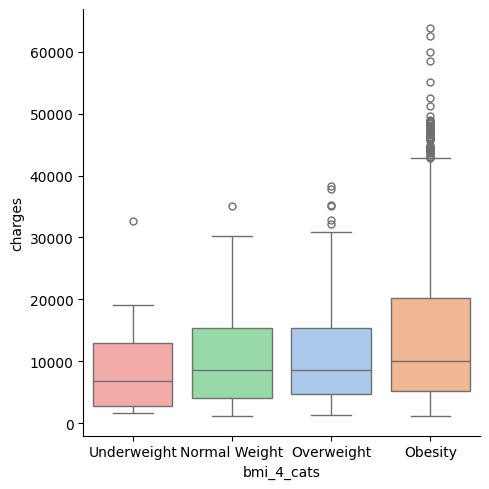

In [51]:
_ = sns.catplot(x="bmi_4_cats",
                y="charges",
                hue="bmi_4_cats",
                order=['Underweight', 'Normal Weight', 'Overweight', 'Obesity'],
                data=cleaned_df,
                legend=False,
                kind="box")
# TODO: order categories

#### Six Categories

In [52]:
def split_bmi_in_six(x: float) -> str:
    if x < 18.5:
        return "Underweight"
    if x < 25:
        return "Normal Weight"
    if x < 30:
        return "Overweight"
    if x < 35:
        return "Class I Obesity"
    if x < 40:
        return "Class II Obesity"
    return "Class III Obesity"

In [53]:
cleaned_df["bmi_6_cats"] = \
cleaned_df.bmi.apply(split_bmi_in_six)

In [54]:
cleaned_df.bmi_6_cats.value_counts()

bmi_6_cats
Class I Obesity      390
Overweight           386
Normal Weight        225
Class II Obesity     225
Class III Obesity     91
Underweight           20
Name: count, dtype: int64

#### `charges` / `bmi_6_cats`

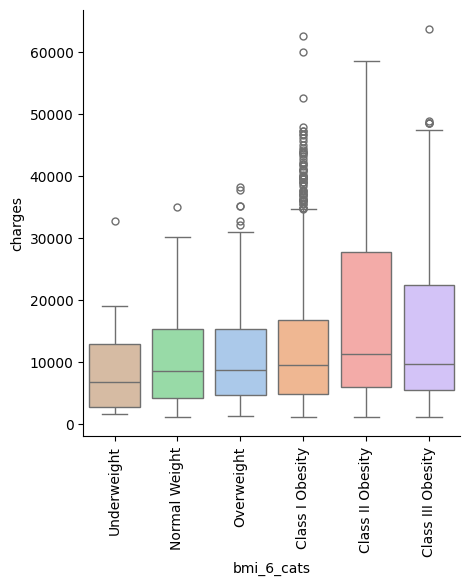

In [55]:
sns.catplot(x="bmi_6_cats", 
            y="charges",
            hue="bmi_6_cats",  # Try smoker
            order=[
                'Underweight', 'Normal Weight', 'Overweight',
                'Class I Obesity', 'Class II Obesity', 'Class III Obesity'
            ],
            data=cleaned_df,
            legend=False,
            kind="box")
plt.xticks(rotation=90)
plt.savefig("graphs/boxplot_bmi_6_cats.png", dpi=300)
plt.show()

In [56]:
cleaned_df.query("sex == 'female'").charges.mean()

12569.578843835347

In [57]:
cleaned_df.query("sex == 'male'").charges.mean()

13974.998863762965

# Statistical Tests

## Nominal / Nominal (Chi-Square)

☝️ <font color="orangered">**For our experiments, we will choose a threshold of $0.05$ for p-values.**</font>

In [58]:
cleaned_df.head()

age     sex     bmi  children smoker     region      charges  \
0   19  female  27.900         0    yes  southwest  16884.92400   
1   18    male  33.770         1     no  southeast   1725.55230   
2   28    male  33.000         3     no  southeast   4449.46200   
3   33    male  22.705         0     no  northwest  21984.47061   
4   32    male  28.880         0     no  northwest   3866.85520   

      bmi_4_cats       bmi_6_cats  
0     Overweight       Overweight  
1        Obesity  Class I Obesity  
2        Obesity  Class I Obesity  
3  Normal Weight    Normal Weight  
4     Overweight       Overweight

### smoker and sex

In [59]:
smoker_sex_ct = contingency_table("smoker", "sex")
smoker_sex_ct

sex     female  male
smoker              
no         547   516
yes        115   159

In [60]:
chi2, p, dof, expected = chi2_contingency(smoker_sex_ct)

In [61]:
p

0.0062765550120107375

👉 <font color="orangered">**The value of `p` being very low indicates the results are statistically significant. Hence, we have to reject the null hypothesis, meaning our variables are correlated.**</font>

In [62]:
cramers_v(smoker_sex_ct, chi2)

0.06958169739999516

👉 <font color="orangered">**This value is really low, telling us that, of course, a correlation exists, but it's really low.**</font>

### sex and region

In [63]:
sex_region_ct = contingency_table("sex", "region")
sex_region_ct

region  northeast  northwest  southeast  southwest
sex                                               
female        161        164        175        162
male          163        160        189        163

In [64]:
chi2, p, dof, expected = chi2_contingency(sex_region_ct)

In [65]:
p

0.9239341965125791

👉 <font color="orangered">**Obviously, there's absolutely no correlation between these two nominal features.**</font>

### smoker and region

In [66]:
smoker_region_ct = contingency_table("smoker", "region")
smoker_region_ct

region  northeast  northwest  southeast  southwest
smoker                                            
no            257        266        273        267
yes            67         58         91         58

In [67]:
chi2, p, dof, expected = chi2_contingency(smoker_region_ct)

In [68]:
p

0.06354826573182332

👉 <font color="orangered">**The p-value being greater than our chosen threshold, we fail to reject the null hypothesis, and conclude these variables are not correlated.**</font>

## Numerical / Numerical (Pearson)

☝️ <font color="orangered">**We will make use of correlation matrix and heatmaps to display them in a fancier way**</font>

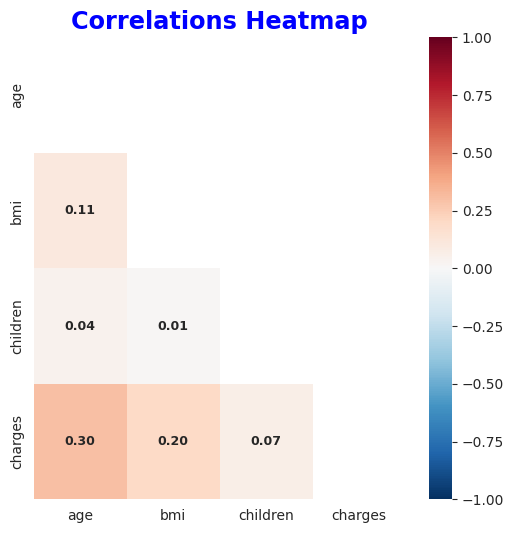

In [69]:
correlation_heatmap()

👉 <font color="orangered">**The real worth mentioning correlation are the positive one existing between `age` and `bmi` with the `charges` target.**</font>

## Nominal-Numerical (pearsonr or ANOVA)

☝️ <font color="orangered">**For binary features, it is adapted to use `pearsonr` (but they need to be encoded beforehand)**</font>

### Binary - Numerical

What this means, is that we can extend the correlation heatmap, not omitting to encode binary variables just before it.

In [70]:
sex_mapping = {"female": 0, "male": 1}
smoker_mapping = {"no": 0, "yes": 1}

bin_cleaned_df = cleaned_df.assign(
    sex = cleaned_df.sex.map(sex_mapping),
    smoker = cleaned_df.smoker.map(smoker_mapping)
)

In [71]:
bin_cleaned_df.dtypes

age             int64
sex             int64
bmi           float64
children        int64
smoker          int64
region         object
charges       float64
bmi_4_cats     object
bmi_6_cats     object
dtype: object

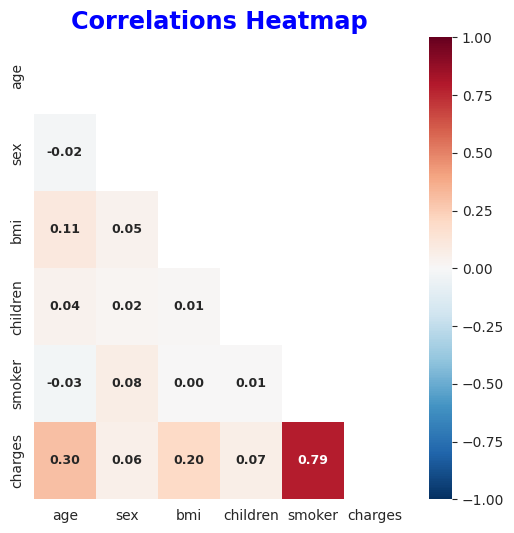

In [72]:
correlation_heatmap(bin_cleaned_df)

👉 <font color="orangered">**As expected, `smoker` is strongly positively correlated with the target.**</font>

### Nominal - Numerical

#### `region` and `charges`

In [73]:
one_way_anova("region")

(2.926139903662777, 0.03276288025444947)

👉 <font color="orangered">**This suggests that there indeed ARE differences between the groups (`p_value` is under the threshold, hence we can reject the null hypothesis). Nevertheless, as the `f_statistic` is rather low, these differences appear to be minor.**</font>

#### `bmi_6_cats` and `charges`

In [74]:
one_way_anova("bmi_6_cats")

(12.934965167921401, 2.616799795337035e-12)

👉 <font color="orangered">**This confirms visual analysis led on boxplots in 6.2.4.4.**</font>

☝️ <font color="orangered">**Now, post-hoc tests(like Tukey's HSD) could be led to go further to get more precise results about differences between the groups.**</font>

#### `region` and `age`

In [75]:
one_way_anova("region", "age")

(0.08076542411471926, 0.9704766241943267)

**As expected, there's obviously no correlation.**

#### `bmi_6_cats` and `age`

In [76]:
one_way_anova("bmi_6_cats", "age")

(4.312864796550523, 0.0006759301475489024)

👉 **Let's cross this result with a `boxplot`**

In [77]:
cleaned_df.bmi_6_cats.unique()

array(['Overweight', 'Class I Obesity', 'Normal Weight',
       'Class II Obesity', 'Class III Obesity', 'Underweight'],
      dtype=object)

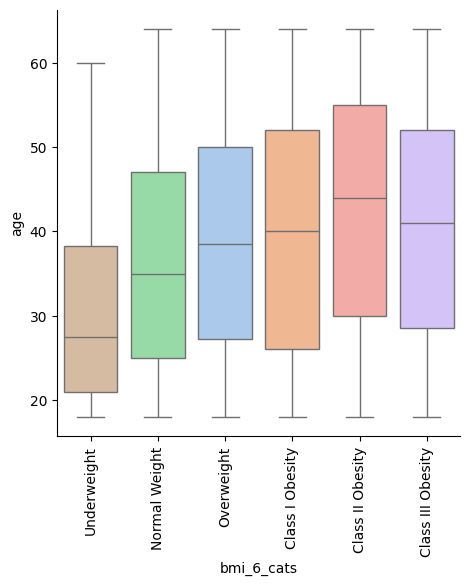

In [78]:
sns.catplot(x="bmi_6_cats", 
            y="age",
            hue="bmi_6_cats",  # Try smoker
            order=[
                'Underweight', 'Normal Weight', 'Overweight',
                'Class I Obesity', 'Class II Obesity', 'Class III Obesity'
            ],      
            data=cleaned_df,
            legend=False,
            kind="box")
plt.xticks(rotation=90)
# plt.savefig("graphs/boxplot_bmi_7_cats.png", dpi=300)
plt.show()

# Managing Target's Skewness

☝️ <font color="orangered">**Target's variable is right-skewed and this can be a problem when wanting to estimate it with linear regression. Therefore, we will try to modify its distribution, in order for it to look more "normal" (mathematically speaking)**</font>

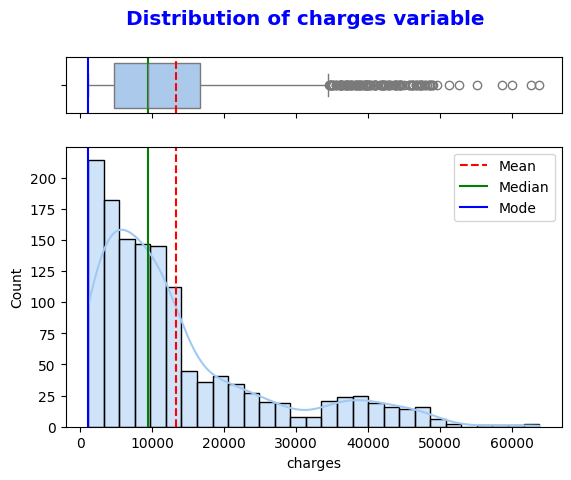

In [79]:
# As a reminder
hist_box_plot(cleaned_df, "charges")

👉 <font color="orangered">**Our strategy will be to try modifying the shape, then check with a "normality visual test", i.e. the `qqplot`**</font>

## Using square root

In [80]:
# Using log, adding 1 to prevent zero charges
cleaned_df["sqrt_charges"] = np.sqrt(cleaned_df.charges)

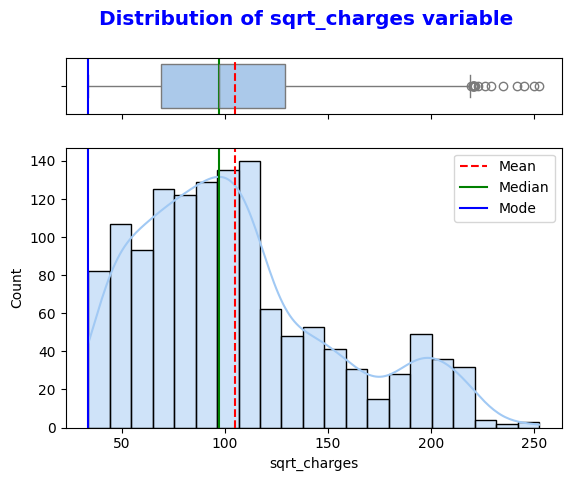

In [81]:
hist_box_plot(cleaned_df, "sqrt_charges", out=True)

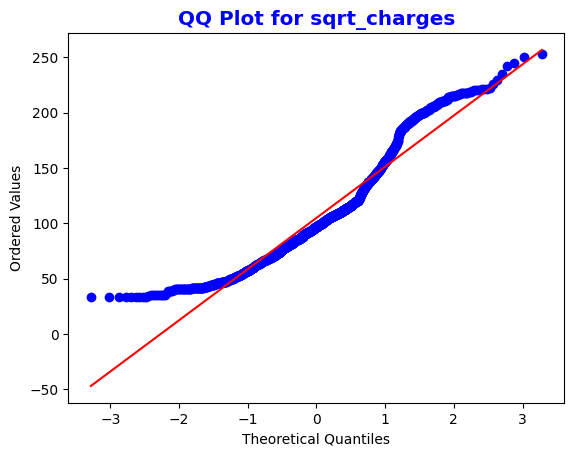

In [82]:
draw_probplot("sqrt_charges", out=True)

## Using $log$

In [83]:
# Using log, adding 1 to prevent zero charges
cleaned_df["log_charges"] = np.log(cleaned_df.charges + 1)

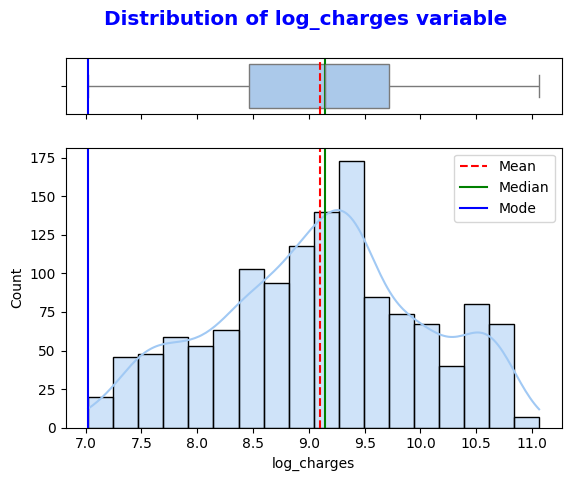

In [84]:
hist_box_plot(cleaned_df, "log_charges", out=True)

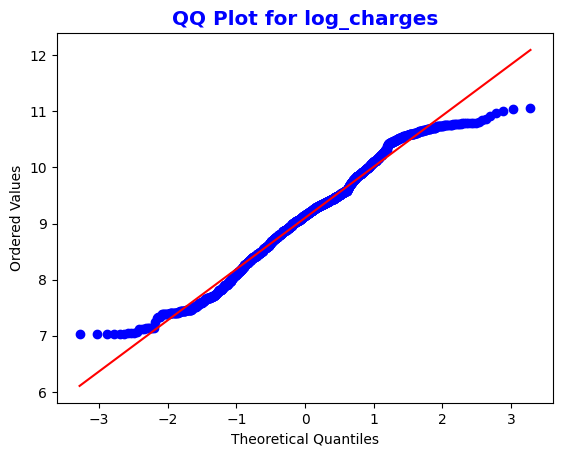

In [85]:
draw_probplot("log_charges", out=True)

## Using `BoxCox`

In [86]:
cleaned_df["boxcox_charges"], fitted_lambda = boxcox(cleaned_df["charges"])

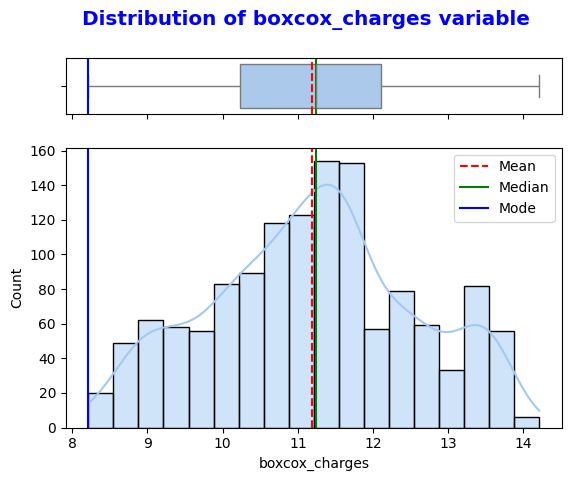

In [87]:
hist_box_plot(cleaned_df, "boxcox_charges", out=True)

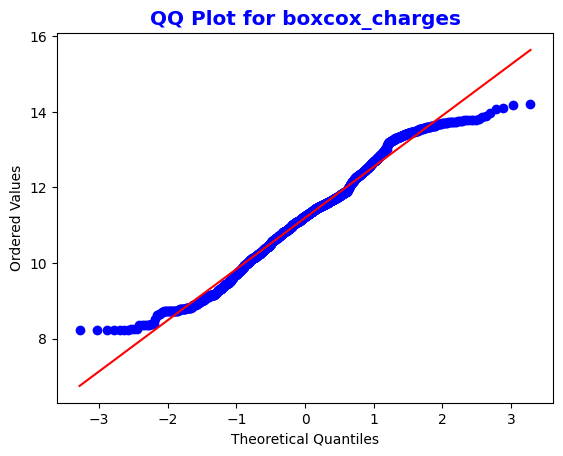

In [88]:
draw_probplot("boxcox_charges", out=True)

👉 <font color="orangered">**This doesn't seem to be better than the affine + logarithm we previously used. Hence, we'll keep this for simplicity.**</font>

# ❓ Polynomial Features

## Encoding

In [89]:
cleaned_df['smoker_bin'] = cleaned_df['smoker'].map({'no': 0, 'yes': 1})
cleaned_df['sex_bin'] = cleaned_df['sex'].map({'female': 0, 'male': 1})
cleaned_df

age     sex     bmi  children smoker     region      charges  \
0      19  female  27.900         0    yes  southwest  16884.92400   
1      18    male  33.770         1     no  southeast   1725.55230   
2      28    male  33.000         3     no  southeast   4449.46200   
3      33    male  22.705         0     no  northwest  21984.47061   
4      32    male  28.880         0     no  northwest   3866.85520   
...   ...     ...     ...       ...    ...        ...          ...   
1332   50    male  30.970         3     no  northwest  10600.54830   
1333   18  female  31.920         0     no  northeast   2205.98080   
1334   18  female  36.850         0     no  southeast   1629.83350   
1335   21  female  25.800         0     no  southwest   2007.94500   
1336   61  female  29.070         0    yes  northwest  29141.36030   

         bmi_4_cats        bmi_6_cats  sqrt_charges  log_charges  \
0        Overweight        Overweight    129.942002     9.734236   
1           Obesity   Class I Obesity     41.539768     7.453882   
2           Obesity   Class I Obesity     66.704288     8.400763   
3     Normal Weight     Normal Weight    148.271611     9.998137   
4        Overweight        Overweight     62.184043     8.260455   
...             ...               ...           ...          ...   
1332        Obesity   Class I Obesity    102.958964     9.268755   
1333        Obesity   Class I Obesity     46.967870     7.699381   
1334        Obesity  Class II Obesity     40.371196     7.396847   
1335     Overweight        Overweight     44.810099     7.605365   
1336     Overweight        Overweight    170.708407    10.279948   

      boxcox_charges  smoker_bin  sex_bin  
0          12.120634           1        0  
1           8.804026           0        1  
2          10.141549           0        1  
3          12.526076           0        1  
4           9.939887           0        1  
...              ...         ...      ...  
1332       11.416735           0        1  
1333        9.145579           0        0  
1334        8.725190           0        0  
1335        9.014352           0        0  
1336       12.964199           1        0  

[1337 rows x 14 columns]

## age $\times$ smoker

In [90]:
cleaned_df["age_x_smoker"] = cleaned_df.age * cleaned_df.smoker_bin

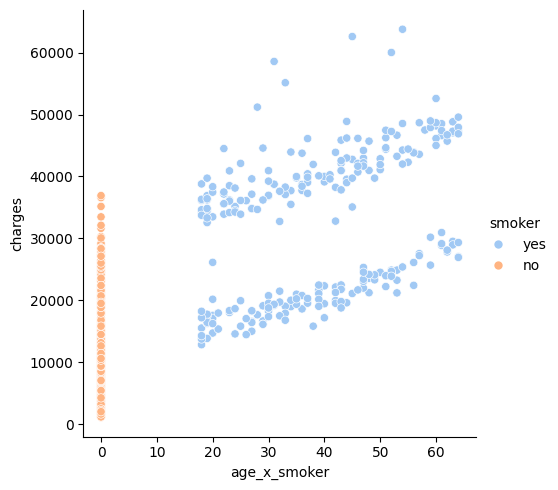

In [91]:
sns.relplot(x="age_x_smoker", y="charges", data=cleaned_df,
            kind="scatter",
            hue="smoker")
plt.show()

## age $\times$ bmi

In [92]:
cleaned_df['age_x_bmi'] = cleaned_df.age * cleaned_df.bmi

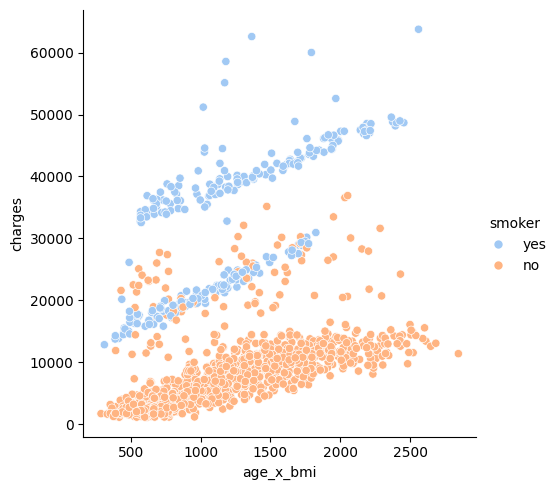

In [93]:
sns.relplot(x="age_x_bmi", y="charges", data=cleaned_df,
            kind="scatter",
            hue="smoker")
plt.show()

## smoker $\times$ bmi

In [94]:
cleaned_df["smoker_x_bmi"] = cleaned_df.smoker_bin * cleaned_df.bmi

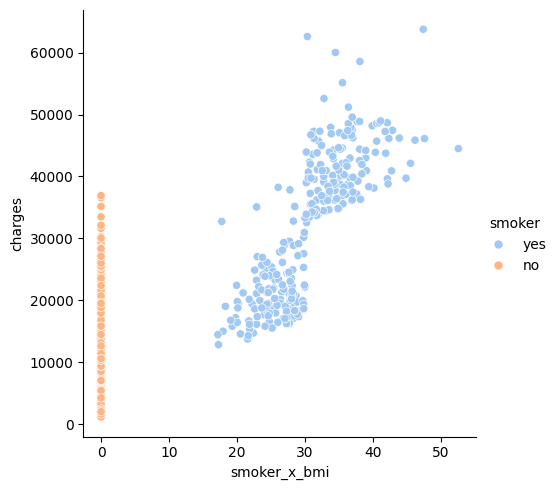

In [95]:
sns.relplot(x="smoker_x_bmi", y="charges", data=cleaned_df,
            kind="scatter",
            hue="smoker")
plt.show()

Test